<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/GradCAM_CNN_Vs_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GradCAM_V1

In [7]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


total gradcam time: 3.4221370220184326


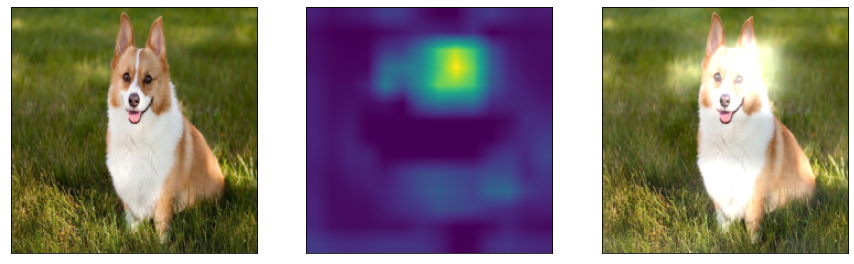

In [51]:
from urllib.request import urlretrieve
from PIL import Image
import os
import cv2
import time

def get_gradcam_multiclass(model, img):
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    # get the gradient of the output with respect to the parameters of the model
    logits[:, pred].backward(retain_graph=True)
    # pull the gradients out of the model
    gradients = model.get_activations_gradient()
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    # get the activations of the last convolutional layer
    activations = model.get_activations(img).detach()
    # weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()
    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)
    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    return heatmap
    
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))
img_url = 'https://www.animalfunfacts.net/images/stories/pets/dogs/pembroke_welsh_corgi_l.jpg'
urlretrieve(img_url, "img.jpg")
std = torch.tensor([0.229, 0.224, 0.225])
mean = torch.tensor([0.485, 0.456, 0.406])
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
img = Image.open("img.jpg")
img = transform(img)[None]

# initialize the VGG model
model = VGG()
# set the evaluation mode
model.eval()
st = time.time()
heatmap = get_gradcam_multiclass(model, img)
et = time.time()
print('total gradcam time:',et-st)
heatmap = heatmap.numpy()
img_rev = img * std[:,None, None] + mean[:,None, None]
img_rev = img_rev.squeeze().permute(1,2,0)
heatmap = cv2.resize(heatmap, (img_rev.shape[1], img_rev.shape[0]))
superimposed_img = np.array(img_rev) + heatmap[:,:,None] * 0.9
#plt.matshow(superimposed_img)

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_rev))
ax[1].imshow(heatmap)
ax[2].imshow(superimposed_img)

# GradCAM_V2

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


total gradcam time: 2.4846231937408447


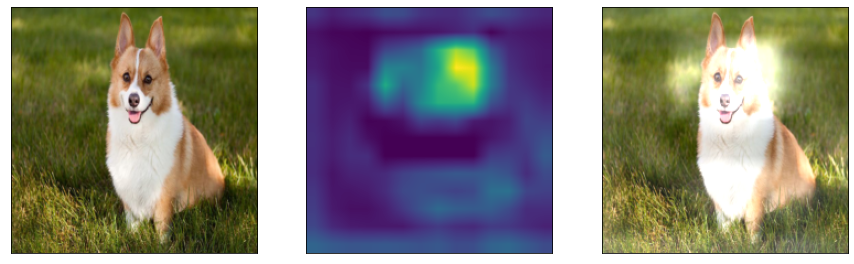

In [52]:
import torch 
import torch.nn.functional as F

def reg_hook_gradcam(last_conv_layer=None):
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    model.eval()
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    # logits[:, pred].backward or logits.backward(pred_onehot[None] yields same result
    # pred_onehot = F.one_hot(pred, num_classes=1000)
    # logits.backward(pred_onehot[None], retain_graph=True)
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]
    # sum or mean produces similar outcomes
    #heatmap = torch.sum(activations, dim=1).squeeze().cpu()
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap

model = vgg19(pretrained=True)
model.eval();
last_conv_layer = model.features[34]
st = time.time()
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)
et = time.time()
print('total gradcam time:',et-st)
heatmap = heatmap.numpy()
img_rev = img * std[:,None, None] + mean[:,None, None]
img_rev = img_rev.squeeze().permute(1,2,0)
heatmap = cv2.resize(heatmap, (img_rev.shape[1], img_rev.shape[0]))
superimposed_img = np.array(img_rev) + heatmap[:,:,None] * 0.9
#plt.matshow(superimposed_img)

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_rev))
ax[1].imshow(heatmap)
ax[2].imshow(superimposed_img)

# GradCAM_ViT_V1
Installation

In [53]:
!pip -q install timm

     |████████████████████████████████| 509 kB 8.3 MB/s 


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


total gradcam time: 2.502833843231201


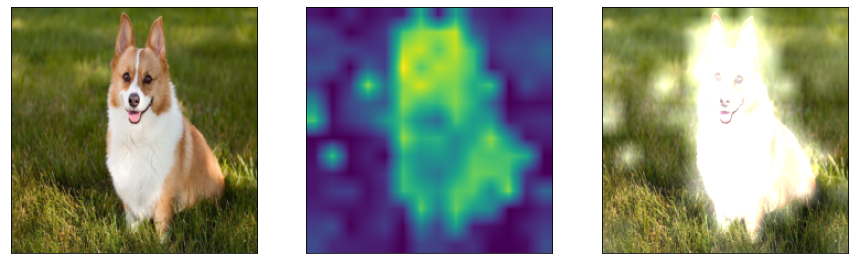

In [100]:
class ViT_Features(nn.Module):
    def __init__(self):
        super(ViT_Features, self).__init__()
        model_name = "vit_base_patch16_224"
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
        self.vit = create_model(model_name, pretrained=True).to(device)

    def forward(self, x):
        patches = self.vit.patch_embed(x)
        pos_embed = self.vit.pos_embed
        transformer_input = torch.cat((self.vit.cls_token, patches), dim=1) + pos_embed #[1, 197, 768]
        x = transformer_input.clone() # critical part, it doesn't work w/o cloning
        for i, blk in enumerate(self.vit.blocks):
            x = blk(x)
        x = self.vit.norm(x)
        transformer_output =  x[:, 0]
        logits = self.vit.head(transformer_output)
        return logits

model = ViT_Features()
model.eval()
last_conv_layer = model.vit.blocks[11].norm1
st = time.time()
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)
et = time.time()
print('total gradcam time:',et-st)
heatmap = heatmap.numpy()
img_rev = img * std[:,None, None] + mean[:,None, None]
img_rev = img_rev.squeeze().permute(1,2,0)
heatmap = cv2.resize(heatmap, (img_rev.shape[1], img_rev.shape[0]))
superimposed_img = np.array(img_rev) + heatmap[:,:,None] * 0.9

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_rev))
ax[1].imshow(heatmap)
ax[2].imshow(superimposed_img)

# GradCAM_ViT_V2

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


total gradcam time: 2.4498398303985596


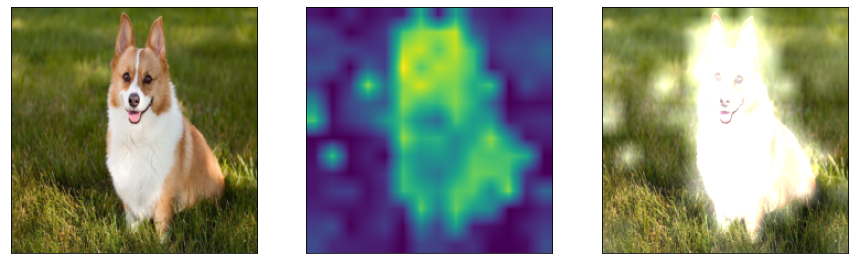

In [64]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from timm import create_model


import torch 
import torch.nn.functional as F

def reg_hook_gradcam(last_conv_layer=None):
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))
    # Bring the channels to the first dimension like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    gradients = reshape_transform(gradients)
    activations = reshape_transform(activations)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap

model_name = "vit_base_patch16_224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
model = create_model(model_name, pretrained=True).to(device)
model.eval()
last_conv_layer = model.blocks[11].norm1
st = time.time()
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)
et = time.time()
print('total gradcam time:',et-st)
heatmap = heatmap.numpy()
img_rev = img * std[:,None, None] + mean[:,None, None]
img_rev = img_rev.squeeze().permute(1,2,0)
heatmap = cv2.resize(heatmap, (img_rev.shape[1], img_rev.shape[0]))
superimposed_img = np.array(img_rev) + heatmap[:,:,None] * 0.9
#plt.matshow(superimposed_img)

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_rev))
ax[1].imshow(heatmap)
ax[2].imshow(superimposed_img)